In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv("Metro_Interstate_Traffic_Volume.csv")
df['date_time'] = pd.to_datetime(df['date_time'])
df['hour'] = df['date_time'].dt.hour
df['day_of_week'] = df['date_time'].dt.dayofweek
df['month'] = df['date_time'].dt.month
df['year'] = df['date_time'].dt.year

In [14]:
df.head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume,hour,day_of_week,month,year
0,NaN,288.28,0.0,0.0,40,Clouds,scattered clouds,2012-10-02 09:00:00,5545,9,1,10,2012
1,NaN,289.36,0.0,0.0,75,Clouds,broken clouds,2012-10-02 10:00:00,4516,10,1,10,2012
2,NaN,289.58,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 11:00:00,4767,11,1,10,2012
3,NaN,290.13,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 12:00:00,5026,12,1,10,2012
4,NaN,291.14,0.0,0.0,75,Clouds,broken clouds,2012-10-02 13:00:00,4918,13,1,10,2012


In [15]:
def rbf_kernel(x1, x2, length_scale=1.0, variance=1.0):
    """Compute the RBF kernel between x1 and x2"""
    x1 = np.atleast_2d(x1).T
    x2 = np.atleast_2d(x2).T
    sqdist = np.sum(x1**2, 1).reshape(-1, 1) + np.sum(x2**2, 1) - 2 * np.dot(x1, x2.T)
    return variance * np.exp(-0.5 / length_scale**2 * sqdist)

def gp_posterior(X_train, y_train, X_test, kernel, noise=1e-8):
    """Compute posterior mean and covariance of GP"""
    K = kernel(X_train, X_train) + noise * np.eye(len(X_train))
    K_s = kernel(X_train, X_test)
    K_ss = kernel(X_test, X_test) + 1e-8 * np.eye(len(X_test))

    K_inv = np.linalg.inv(K)

    mu_s = K_s.T.dot(K_inv).dot(y_train)
    cov_s = K_ss - K_s.T.dot(K_inv).dot(K_s)

    return mu_s, cov_s

def linear_kernel(x1, x2, c=0.0):
    x1 = np.atleast_2d(x1).T
    x2 = np.atleast_2d(x2).T
    return (x1 @ x2.T) + c

def periodic_kernel(x1, x2, length_scale=1.0, period=24.0, variance=1.0):
    x1 = np.atleast_2d(x1).T
    x2 = np.atleast_2d(x2).T
    dists = np.pi * np.abs(x1 - x2.T) / period
    return variance * np.exp(-2 * (np.sin(dists)**2) / length_scale**2)

def rational_quadratic_kernel(x1, x2, length_scale=1.0, alpha=1.0, variance=1.0):
    x1 = np.atleast_2d(x1).T
    x2 = np.atleast_2d(x2).T
    sqdist = np.sum(x1**2, 1).reshape(-1, 1) + np.sum(x2**2, 1) - 2 * np.dot(x1, x2.T)
    return variance * (1 + sqdist / (2 * alpha * length_scale**2))**(-alpha)

def combined_kernel(x1, x2):
    return rbf_kernel(x1, x2) + periodic_kernel(x1, x2)

In [16]:
def rbf_plus_linear_kernel(x1, x2, length_scale=1.0, variance=1.0, slope=1.0):
    """RBF + Linear kernel mixture"""
    x1 = np.atleast_2d(x1).T
    x2 = np.atleast_2d(x2).T
    sqdist = np.sum(x1**2, 1).reshape(-1, 1) + np.sum(x2**2, 1) - 2 * np.dot(x1, x2.T)
    rbf = variance * np.exp(-0.5 / length_scale**2 * sqdist)
    linear = slope * (x1 @ x2.T)
    return rbf + linear

def rbf_times_periodic_kernel(x1, x2, length_scale=1.0, variance=1.0, periodicity=24.0):
    """RBF * Periodic kernel mixture"""
    x1 = np.atleast_2d(x1).T
    x2 = np.atleast_2d(x2).T
    dist = np.abs(x1 - x2.T)
    periodic = np.exp(-2 * (np.sin(np.pi * dist / periodicity) ** 2))
    sqdist = np.sum(x1**2, 1).reshape(-1, 1) + np.sum(x2**2, 1) - 2 * np.dot(x1, x2.T)
    rbf = variance * np.exp(-0.5 / length_scale**2 * sqdist)
    return rbf * periodic


In [18]:
df['time_step'] = (df['date_time'] - pd.Timestamp("1970-01-01")) // pd.Timedelta(hours=1)


In [17]:
# Training data (e.g., noisy sine wave)
df_train = df[df['date_time'].dt.year <= 2015]
df_valid = df[df['date_time'].dt.year == 2016]
df_test = df[df['date_time'].dt.year >= 2017]

# Test points
X_train = df_train['time_step']
X_test = df_train['time_step']

y_train = df_train['traffic_volume']
y_test = df_train['traffic_volume']

In [19]:
kernels = {
    "RBF": rbf_kernel,
    "Linear": linear_kernel,
    "Periodic": periodic_kernel,
    "RationalQuadratic": rational_quadratic_kernel,
    "Combined": combined_kernel,
    "RBFPlusLinearKernel":rbf_plus_linear_kernel,
    "RBFTimesPeriodicKernel":rbf_times_periodic_kernel
}

K_matrices = {}

for name, kernel_func in kernels.items():
    K_matrices[name] = kernel_func(X_train, X_train) + 1e-6 * np.eye(len(X_train))


MemoryError: Unable to allocate 3.08 GiB for an array with shape (20344, 20344) and data type int64

In [8]:
K = rbf_kernel(X_train, X_train) + 1e-8 * np.eye(len(X_train))

In [17]:
K_inv = np.linalg.inv(K)

In [9]:
# GP prediction
mu_s, cov_s = gp_posterior(X_train, y_train, X_test, rbf_kernel)

# Compute uncertainty bounds
stdv = np.sqrt(np.diag(cov_s))
upper = mu_s + 2 * stdv
lower = mu_s - 2 * stdv

KeyboardInterrupt: 

In [10]:
X_train[-24*7:].max()

403223

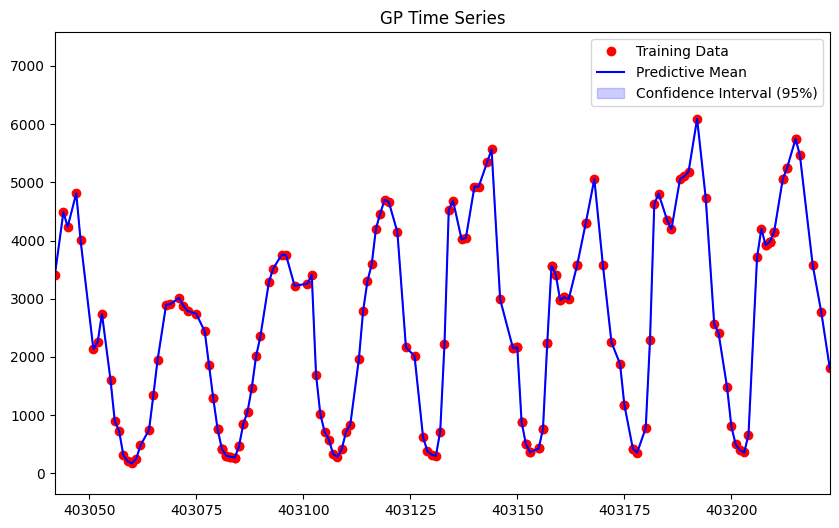

In [29]:
# Plot
plt.figure(figsize=(10, 6))
plt.plot(X_train[-24*7:], y_train[-24*7:], 'ro', label='Training Data')
plt.plot(X_test[-24*7:], mu_s[-24*7:], 'b-', label='Predictive Mean')
plt.fill_between(X_test, lower, upper, color='blue', alpha=0.2, label='Confidence Interval (95%)')
plt.title("GP Time Series")
plt.legend()
plt.xlim([403042, 403223])
plt.show()

In [11]:
# --- GP with RBF + Linear ---
mu_s, cov_s = gp_posterior(X_train, y_train, X_test, rbf_plus_linear_kernel)
stdv = np.sqrt(np.diag(cov_s))
upper = mu_s + 2 * stdv
lower = mu_s - 2 * stdv

plt.figure(figsize=(10, 6))
plt.plot(X_train[-24*7:], y_train[-24*7:], 'ro', label='Training Data')
plt.plot(X_test[-24*7:], mu_s[-24*7:], 'g-', label='Predictive Mean')
plt.fill_between(X_test[-24*7:], lower[-24*7:], upper[-24*7:], color='green', alpha=0.2)
plt.title("GP with RBF + Linear")
plt.legend()
plt.xlim([403042, 403223])
plt.show()


LinAlgError: Singular matrix

In [ ]:
# --- GP with RBF × Periodic ---
mu_s, cov_s = gp_posterior(X_train, y_train, X_test, rbf_times_periodic_kernel)
stdv = np.sqrt(np.diag(cov_s))
upper = mu_s + 2 * stdv
lower = mu_s - 2 * stdv

plt.figure(figsize=(10, 6))
plt.plot(X_train[-24*7:], y_train[-24*7:], 'ro', label='Training Data')
plt.plot(X_test[-24*7:], mu_s[-24*7:], 'g-', label='Predictive Mean')
plt.fill_between(X_test[-24*7:], lower[-24*7:], upper[-24*7:], color='green', alpha=0.2)
plt.title("GP with RBF × Periodic")
plt.legend()
plt.xlim([403042, 403223])
plt.show()
